In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time

Implémentation de l'environnement TicTacToe

In [2]:
class TicTacToe:
    def __init__(self):
        self.reset()

    def reset(self):
        self.board = [' '] * 9
        self.current_player = 'X'
        return self.board.copy()

    def step(self, action):
        if self.board[action] != ' ':
            return self.board.copy(), -10, True, {"invalid": True}

        self.board[action] = self.current_player
        if self.check_win(self.current_player):
            return self.board.copy(), 1, True, {}

        if ' ' not in self.board:
            return self.board.copy(), 0, True, {}

        # adversaire random
        opponent_move = random.choice([i for i, v in enumerate(self.board) if v == ' '])
        self.board[opponent_move] = 'O'
        if self.check_win('O'):
            return self.board.copy(), -1, True, {}

        return self.board.copy(), 0, False, {}

    def check_win(self, player):
        wins = [(0,1,2), (3,4,5), (6,7,8), (0,3,6), (1,4,7), (2,5,8), (0,4,8), (2,4,6)]
        return any(all(self.board[i] == player for i in combo) for combo in wins)

    def render(self):
        for i in range(3):
            print(self.board[3*i:3*(i+1)])


Random

In [3]:
import random
class RandomAgent:
    def select_action(self, state):
        return random.choice([i for i, v in enumerate(state) if v == ' '])

    def learn(self, *args, **kwargs):
        pass

In [4]:
def train_agent(agent, env, episodes=1000):
    rewards = []
    lengths = []
    for ep in range(episodes):
        state = env.reset()
        done = False
        ep_reward = 0
        steps = 0
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            ep_reward += reward
            steps += 1
        rewards.append(ep_reward)
        lengths.append(steps)
        if (ep + 1) % 100 == 0:
            print(f"Episode {ep+1}/{episodes} - Moyenne des 100 derniers rewards : {np.mean(rewards[-100:]):.3f}")
    return rewards, lengths

def evaluate_agent(agent, env, episodes=100):
    rewards = []
    lengths = []
    action_times = []
    for _ in range(episodes):
        state = env.reset()
        done = False
        ep_reward = 0
        steps = 0
        while not done:
            start = time.time()
            action = agent.select_action(state)
            action_times.append(time.time() - start)
            state, reward, done, info = env.step(action)
            ep_reward += reward
            steps += 1
        rewards.append(ep_reward)
        lengths.append(steps)
    return {
        "score_moyen": np.mean(rewards),
        "longueur_moyenne": np.mean(lengths),
        "temps_moyen_action": np.mean(action_times) * 1000  # en ms
    }

 Entraînement de l'agent Random...
Episode 100/1000 - Moyenne des 100 derniers rewards : 0.430
Episode 200/1000 - Moyenne des 100 derniers rewards : 0.340
Episode 300/1000 - Moyenne des 100 derniers rewards : 0.120
Episode 400/1000 - Moyenne des 100 derniers rewards : 0.180
Episode 500/1000 - Moyenne des 100 derniers rewards : 0.330
Episode 600/1000 - Moyenne des 100 derniers rewards : 0.360
Episode 700/1000 - Moyenne des 100 derniers rewards : 0.180
Episode 800/1000 - Moyenne des 100 derniers rewards : 0.240
Episode 900/1000 - Moyenne des 100 derniers rewards : 0.340
Episode 1000/1000 - Moyenne des 100 derniers rewards : 0.390

 Graphique des récompenses


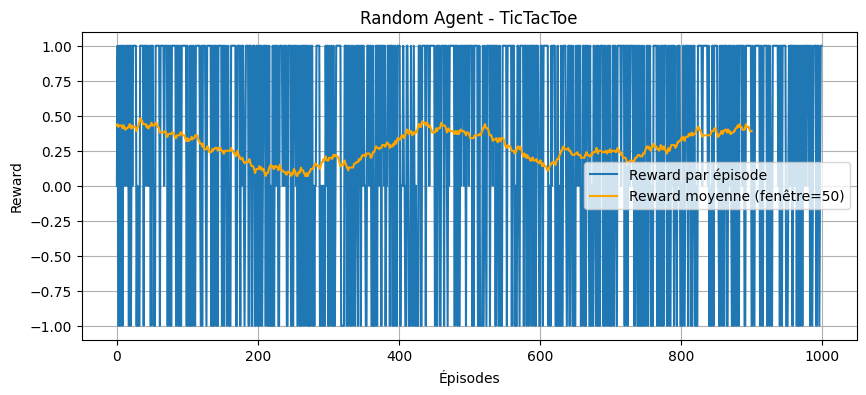


 Évaluation de la policy Random
Score moyen (ε=0): 0.450
Longueur moyenne : 4.06 steps
Temps moyen par action : 0.005 ms


In [5]:
def plot_rewards(rewards, title="Récompenses par épisode"):
    plt.figure(figsize=(10, 4))
    plt.plot(rewards, label='Reward par épisode')
    plt.plot(np.convolve(rewards, np.ones(100)/100, mode='valid'),
             label='Reward moyenne (fenêtre=50)', color='orange')
    plt.xlabel('Épisodes')
    plt.ylabel('Reward')
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()


env = TicTacToe()
random_agent = RandomAgent()

print(" Entraînement de l'agent Random...")
rewards, lengths = train_agent(random_agent, env, episodes=1000)

print("\n Graphique des récompenses")
plot_rewards(rewards, title="Random Agent - TicTacToe")

print("\n Évaluation de la policy Random")
results_random = evaluate_agent(random_agent, env, episodes=100)
print(f"Score moyen (ε=0): {results_random['score_moyen']:.3f}")
print(f"Longueur moyenne : {results_random['longueur_moyenne']:.2f} steps")
print(f"Temps moyen par action : {results_random['temps_moyen_action']:.3f} ms")

TabularQLearning

In [6]:
from collections import defaultdict


class TabularQLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.1):
        self.q_table = defaultdict(lambda: np.zeros(9))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

    def state_to_key(self, state):
        return ''.join(state)

    def select_action(self, state):
        key = self.state_to_key(state)
        if random.random() < self.epsilon:
            available = [i for i, v in enumerate(state) if v == ' ']
            return random.choice(available)
        q_values = self.q_table[key].copy()
        q_values = [q if state[i] == ' ' else -np.inf for i, q in enumerate(q_values)]
        return int(np.argmax(q_values))

    def learn(self, state, action, reward, next_state, done):
        key = self.state_to_key(state)
        next_key = self.state_to_key(next_state)

        max_next_q = max([self.q_table[next_key][i] for i, v in enumerate(next_state) if v == ' '], default=0)
        td_target = reward + self.gamma * max_next_q
        td_error = td_target - self.q_table[key][action]
        self.q_table[key][action] += self.alpha * td_error

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [7]:
def train_agent(agent, env, episodes=1000):
    rewards = []
    lengths = []
    for ep in range(episodes):
        state = env.reset()
        done = False
        ep_reward = 0
        steps = 0
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            ep_reward += reward
            steps += 1
        rewards.append(ep_reward)
        lengths.append(steps)
        if (ep + 1) % 100 == 0:
            print(f"Episode {ep+1}/{episodes} - Moyenne des 100 derniers rewards : {np.mean(rewards[-100:]):.3f}")
    return rewards, lengths

def evaluate_agent(agent, env, episodes=100):
    rewards = []
    lengths = []
    action_times = []
    for _ in range(episodes):
        state = env.reset()
        done = False
        ep_reward = 0
        steps = 0
        while not done:
            start = time.time()
            action = agent.select_action(state)
            action_times.append(time.time() - start)
            state, reward, done, info = env.step(action)
            ep_reward += reward
            steps += 1
        rewards.append(ep_reward)
        lengths.append(steps)
    return {
        "score_moyen": np.mean(rewards),
        "longueur_moyenne": np.mean(lengths),
        "temps_moyen_action": np.mean(action_times) * 1000  # ms
    }


 Entraînement de l'agent Tabular Q-Learning...
Episode 100/1000 - Moyenne des 100 derniers rewards : 0.460
Episode 200/1000 - Moyenne des 100 derniers rewards : 0.630
Episode 300/1000 - Moyenne des 100 derniers rewards : 0.690
Episode 400/1000 - Moyenne des 100 derniers rewards : 0.720
Episode 500/1000 - Moyenne des 100 derniers rewards : 0.620
Episode 600/1000 - Moyenne des 100 derniers rewards : 0.750
Episode 700/1000 - Moyenne des 100 derniers rewards : 0.650
Episode 800/1000 - Moyenne des 100 derniers rewards : 0.710
Episode 900/1000 - Moyenne des 100 derniers rewards : 0.730
Episode 1000/1000 - Moyenne des 100 derniers rewards : 0.760

 Graphique des récompenses


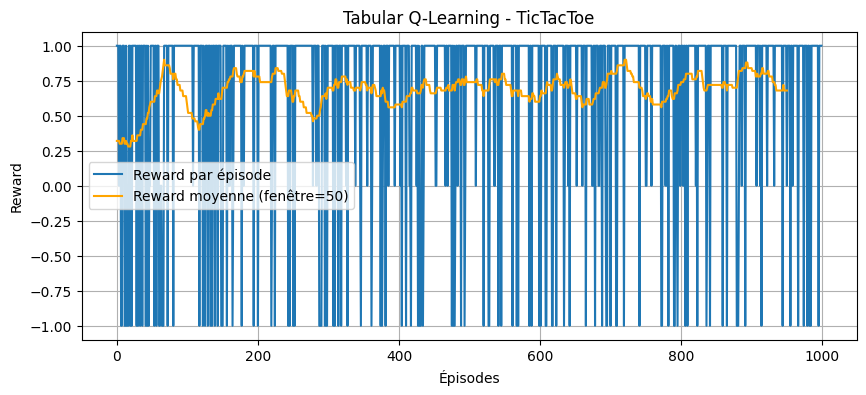


 Évaluation de la policy Tabular Q-Learning
Score moyen (ε=0): 0.720
Longueur moyenne : 3.72 steps
Temps moyen par action : 0.091 ms


In [8]:
def plot_rewards(rewards, title="Récompenses par épisode"):
    plt.figure(figsize=(10, 4))
    plt.plot(rewards, label='Reward par épisode')
    plt.plot(np.convolve(rewards, np.ones(50)/50, mode='valid'),
             label='Reward moyenne (fenêtre=50)', color='orange')
    plt.xlabel('Épisodes')
    plt.ylabel('Reward')
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()


env = TicTacToe()
tabular_agent = TabularQLearningAgent()

print(" Entraînement de l'agent Tabular Q-Learning...")
rewards_tabular, lengths_tabular = train_agent(tabular_agent, env, episodes=1000)

print("\n Graphique des récompenses")
plot_rewards(rewards_tabular, title="Tabular Q-Learning - TicTacToe")

print("\n Évaluation de la policy Tabular Q-Learning")
results_tabular = evaluate_agent(tabular_agent, env, episodes=100)
print(f"Score moyen (ε=0): {results_tabular['score_moyen']:.3f}")
print(f"Longueur moyenne : {results_tabular['longueur_moyenne']:.2f} steps")
print(f"Temps moyen par action : {results_tabular['temps_moyen_action']:.3f} ms")



DeepQLearning

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

class DQNNetwork(nn.Module):
    def __init__(self, input_dim=9, output_dim=9):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

def encode_board(board):
    encoding = {' ': 0, 'X': 1, 'O': -1}
    return np.array([encoding[cell] for cell in board], dtype=np.float32)

class DQNAgent:
    def __init__(self, lr=1e-3, gamma=0.99, epsilon=0.1, epsilon_decay=0.995, epsilon_min=0.1):
        self.model = DQNNetwork()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

    def select_action(self, state):
        available = [i for i, v in enumerate(state) if v == ' ']
        if random.random() < self.epsilon:
            return random.choice(available)
        with torch.no_grad():
            state_encoded = torch.tensor(encode_board(state)).unsqueeze(0)
            q_values = self.model(state_encoded)[0].numpy()
            q_values = [q if state[i] == ' ' else -np.inf for i, q in enumerate(q_values)]
            return int(np.argmax(q_values))

    def learn(self, state, action, reward, next_state, done):
        state_tensor = torch.tensor(encode_board(state)).unsqueeze(0)
        next_state_tensor = torch.tensor(encode_board(next_state)).unsqueeze(0)
        reward_tensor = torch.tensor(reward, dtype=torch.float32)

        q_values = self.model(state_tensor)
        next_q_values = self.model(next_state_tensor)

        target = q_values.clone().detach()
        if done:
            target[0][action] = reward_tensor
        else:
            target[0][action] = reward_tensor + self.gamma * torch.max(next_q_values)

        loss = self.criterion(q_values, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [10]:
def trainDeepQLearningAgent(env, agent, episodes=1000):
    total_rewards = []
    total_steps = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        steps = 0

        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward
            steps += 1

        total_rewards.append(episode_reward)
        total_steps.append(steps)

        if (episode + 1) % 100 == 0:
            print(f"Épisode {episode+1}/{episodes} - Moyenne reward (100 derniers) : {np.mean(total_rewards[-100:]):.3f}")

    return total_rewards, total_steps

def evaluateDeepQLearningAgent(agent, env, episodes=100):
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0

    total_rewards = []
    total_steps = []
    action_times = []

    for _ in range(episodes):
        state = env.reset()
        done = False
        reward_sum = 0
        steps = 0

        while not done:
            start = time.time()
            action = agent.select_action(state)
            action_times.append(time.time() - start)
            state, reward, done, _ = env.step(action)
            reward_sum += reward
            steps += 1

        total_rewards.append(reward_sum)
        total_steps.append(steps)

    agent.epsilon = original_epsilon

    print("\n Évaluation de la policy DQN (ε = 0) :")
    print(f"  - Score moyen : {np.mean(total_rewards):.3f}")
    print(f"  - Longueur moyenne : {np.mean(total_steps):.2f} steps")
    print(f"  - Temps moyen par action : {np.mean(action_times) * 1000:.3f} ms")


 Entraînement de l'agent Deep Q-Learning...
Épisode 100/1000 - Moyenne reward (100 derniers) : 0.570
Épisode 200/1000 - Moyenne reward (100 derniers) : 0.620
Épisode 300/1000 - Moyenne reward (100 derniers) : 0.810
Épisode 400/1000 - Moyenne reward (100 derniers) : 0.680
Épisode 500/1000 - Moyenne reward (100 derniers) : 0.690
Épisode 600/1000 - Moyenne reward (100 derniers) : 0.780
Épisode 700/1000 - Moyenne reward (100 derniers) : 0.680
Épisode 800/1000 - Moyenne reward (100 derniers) : 0.690
Épisode 900/1000 - Moyenne reward (100 derniers) : 0.820
Épisode 1000/1000 - Moyenne reward (100 derniers) : 0.790

 Affichage du graphique des récompenses


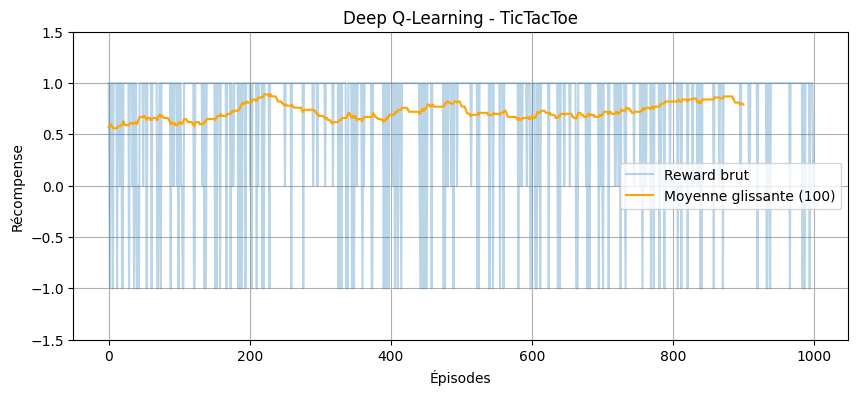


 Résultats d'évaluation de la policy DQN

🎯 Évaluation de la policy DQN (ε = 0) :
  - Score moyen : 0.880
  - Longueur moyenne : 3.56 steps
  - Temps moyen par action : 0.295 ms


In [11]:
def plot_rewards(rewards, title="Deep Q-Learning - Récompenses par épisode"):
    plt.figure(figsize=(10, 4))
    plt.plot(rewards, label="Reward brut", alpha=0.3)
    if len(rewards) >= 100:
        plt.plot(np.convolve(rewards, np.ones(100)/100, mode="valid"),
                 label="Moyenne glissante (100)", color="orange")
    plt.xlabel("Épisodes")
    plt.ylabel("Récompense")
    plt.ylim(-1.5, 1.5)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

env = TicTacToe()
dqn_agent = DQNAgent()

print(" Entraînement de l'agent Deep Q-Learning...")
rewards_dqn, steps_dqn = trainDeepQLearningAgent(env, dqn_agent, episodes=1000)

print("\n Affichage du graphique des récompenses")
plot_rewards(rewards_dqn, title="Deep Q-Learning - TicTacToe")

print("\n Résultats d'évaluation de la policy DQN")
evaluateDeepQLearningAgent(dqn_agent, env, episodes=100)


DoubleDeepQLearningWithExperienceReplay

In [12]:
from collections import deque

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state.copy(), action, reward, next_state.copy(), done))

    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)
        return list(states), list(actions), list(rewards), list(next_states), list(dones)

    def __len__(self):
        return len(self.buffer)

class DoubleDeepQLearningWithExperienceReplay:
    def __init__(self, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.1, lr=1e-3, batch_size=32):
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size

        self.model = DQNNetwork()
        self.target_model = DQNNetwork()
        self.target_model.load_state_dict(self.model.state_dict())

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        self.replay_buffer = ReplayBuffer()
        self.update_counter = 0

    def board_to_tensor(self, board):
        return torch.FloatTensor([(1 if x == 'X' else -1 if x == 'O' else 0) for x in board])

    def select_action(self, board):
        valid_moves = [i for i, v in enumerate(board) if v == ' ']
        if random.random() < self.epsilon:
            return random.choice(valid_moves)
        with torch.no_grad():
            state_tensor = self.board_to_tensor(board).unsqueeze(0)
            q_values = self.model(state_tensor).squeeze()
            q_values = [q_values[i] if i in valid_moves else -1e9 for i in range(9)]
            return int(torch.argmax(torch.tensor(q_values)).item())

    def learn(self, state, action, reward, next_state, done):
        self.replay_buffer.push(state, action, reward, next_state, done)
        if len(self.replay_buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        state_tensors = torch.stack([self.board_to_tensor(s) for s in states])
        next_state_tensors = torch.stack([self.board_to_tensor(ns) for ns in next_states])
        actions_tensor = torch.tensor(actions, dtype=torch.long)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
        dones_tensor = torch.tensor(dones, dtype=torch.float32)

        q_values = self.model(state_tensors).gather(1, actions_tensor.unsqueeze(1)).squeeze()

        with torch.no_grad():
            next_actions = torch.argmax(self.model(next_state_tensors), dim=1)
            next_q_values = self.target_model(next_state_tensors).gather(1, next_actions.unsqueeze(1)).squeeze()
            target_q_values = rewards_tensor + (1 - dones_tensor) * self.gamma * next_q_values

        loss = self.criterion(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.update_counter += 1
        if self.update_counter % 10 == 0:
            self.target_model.load_state_dict(self.model.state_dict())

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [13]:
def trainDoubleDQNReplayAgent(env, agent, episodes=1000):
    rewards = []
    steps = []

    for ep in range(episodes):
        state = env.reset()
        done = False
        ep_reward = 0
        ep_steps = 0

        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            ep_reward += reward
            ep_steps += 1

        rewards.append(ep_reward)
        steps.append(ep_steps)

        if (ep + 1) % 100 == 0:
            print(f"Épisode {ep+1}/{episodes} - Moyenne des 100 derniers : {np.mean(rewards[-100:]):.3f}")

    return rewards, steps

def evaluateDoubleDQNReplayAgent(agent, env, episodes=100):
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0

    rewards = []
    lengths = []
    action_times = []

    for _ in range(episodes):
        state = env.reset()
        done = False
        ep_reward = 0
        ep_steps = 0

        while not done:
            start = time.time()
            action = agent.select_action(state)
            action_times.append(time.time() - start)
            state, reward, done, _ = env.step(action)
            ep_reward += reward
            ep_steps += 1

        rewards.append(ep_reward)
        lengths.append(ep_steps)

    agent.epsilon = original_epsilon

    print("\n Évaluation de la policy Double DQN + Replay (ε = 0) :")
    print(f"  - Score moyen : {np.mean(rewards):.3f}")
    print(f"  - Longueur moyenne : {np.mean(lengths):.2f} steps")
    print(f"  - Temps moyen par action : {np.mean(action_times) * 1000:.3f} ms")


 Entraînement de l'agent Double DQN avec Experience Replay...
Épisode 100/1000 - Moyenne des 100 derniers : 0.170
Épisode 200/1000 - Moyenne des 100 derniers : 0.260
Épisode 300/1000 - Moyenne des 100 derniers : 0.200
Épisode 400/1000 - Moyenne des 100 derniers : 0.290
Épisode 500/1000 - Moyenne des 100 derniers : 0.470
Épisode 600/1000 - Moyenne des 100 derniers : 0.360
Épisode 700/1000 - Moyenne des 100 derniers : 0.430
Épisode 800/1000 - Moyenne des 100 derniers : 0.370
Épisode 900/1000 - Moyenne des 100 derniers : 0.440
Épisode 1000/1000 - Moyenne des 100 derniers : 0.460

 Affichage du graphique


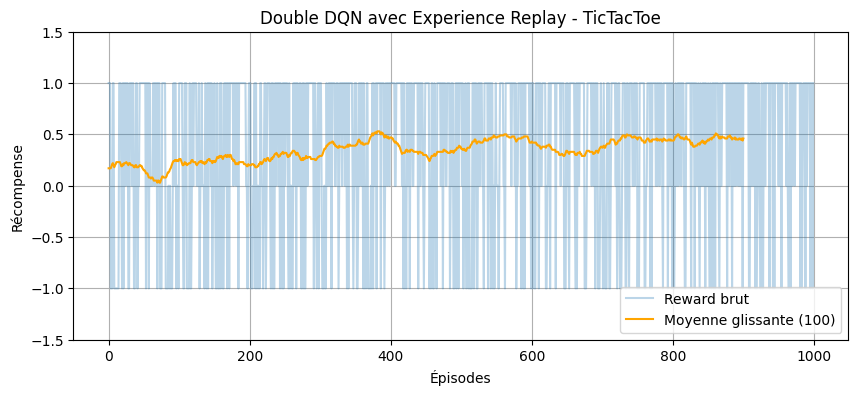


 Évaluation finale

🎯 Évaluation de la policy Double DQN + Replay (ε = 0) :
  - Score moyen : 0.340
  - Longueur moyenne : 4.73 steps
  - Temps moyen par action : 0.198 ms


In [14]:
def plot_rewards(rewards, title="Double DQN + Replay - Récompenses par épisode"):
    plt.figure(figsize=(10, 4))
    plt.plot(rewards, label="Reward brut", alpha=0.3)
    if len(rewards) >= 100:
        plt.plot(np.convolve(rewards, np.ones(100)/100, mode="valid"),
                 label="Moyenne glissante (100)", color="orange")
    plt.xlabel("Épisodes")
    plt.ylabel("Récompense")
    plt.ylim(-1.5, 1.5)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

env = TicTacToe()
ddqn_replay_agent = DoubleDeepQLearningWithExperienceReplay()

print(" Entraînement de l'agent Double DQN avec Experience Replay...")
rewards_ddqn, steps_ddqn = trainDoubleDQNReplayAgent(env, ddqn_replay_agent, episodes=1000)

print("\n Affichage du graphique")
plot_rewards(rewards_ddqn, title="Double DQN avec Experience Replay - TicTacToe")

print("\n Évaluation finale")
evaluateDoubleDQNReplayAgent(ddqn_replay_agent, env, episodes=100)


DoubleDeepQLearningWithPrioritizedExperienceReplay


REINFORCE


REINFORCE with mean baseline

REINFORCE with Baseline Learned by a Critic

PPO A2C style

RandomRollout

Monte Carlo Tree Search (UCT)

Expert Apprentice

Joueur VS Bot

In [15]:
def play_against_agent(agent, env):
    print("Bienvenue dans TicTacToe contre l'agent entraîné !")
    print("Vous êtes 'X' (humain), l'agent est 'O'")
    env.reset()
    human_turn = True

    while True:
        env.render()
        if human_turn:
            try:
                move = int(input("Entrez votre coup (0-8) : "))
                if env.board[move] != ' ':
                    print("Case occupée. Réessayez.")
                    continue
                env.board[move] = 'X'
            except (ValueError, IndexError):
                print("Entrée invalide. Entrez un nombre entre 0 et 8.")
                continue

            if env.check_win('X'):
                env.render()
                print("Vous avez gagné !")
                break
            if ' ' not in env.board:
                env.render()
                print("Match nul.")
                break

            human_turn = False

        else:
            state = env.board.copy()
            action = agent.select_action(state)
            print(f"L'agent joue en case {action}.")
            env.board[action] = 'O'

            if env.check_win('O'):
                env.render()
                print(" L'agent a gagné.")
                break
            if ' ' not in env.board:
                env.render()
                print(" Match nul.")
                break

            human_turn = True


In [16]:
play_against_agent(dqn_agent, TicTacToe())

Bienvenue dans TicTacToe contre l'agent entraîné !
Vous êtes 'X' (humain), l'agent est 'O'
[' ', ' ', ' ']
[' ', ' ', ' ']
[' ', ' ', ' ']
Entrez votre coup (0-8) : 5
[' ', ' ', ' ']
[' ', ' ', 'X']
[' ', ' ', ' ']
L'agent joue en case 6.
[' ', ' ', ' ']
[' ', ' ', 'X']
['O', ' ', ' ']
Entrez votre coup (0-8) : 5
Case occupée. Réessayez.
[' ', ' ', ' ']
[' ', ' ', 'X']
['O', ' ', ' ']
Entrez votre coup (0-8) : 6
Case occupée. Réessayez.
[' ', ' ', ' ']
[' ', ' ', 'X']
['O', ' ', ' ']
Entrez votre coup (0-8) : 4
[' ', ' ', ' ']
[' ', 'X', 'X']
['O', ' ', ' ']
L'agent joue en case 1.
[' ', 'O', ' ']
[' ', 'X', 'X']
['O', ' ', ' ']
Entrez votre coup (0-8) : 3
[' ', 'O', ' ']
['X', 'X', 'X']
['O', ' ', ' ']
Vous avez gagné !
